In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import random
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
from __future__ import unicode_literals
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Setup The enviromental modules

### Import nltk

In [2]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaimemillan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words(['english','danish', 'dutch', 'english', 'finnish', 'french', 'german', 'hungarian', 'italian', 'norwegian', 'portuguese', 'russian', 'spanish', 'swedish', 'turkish'])
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

## Get The podcast Data 

### Here we import the podcast data. At the end we will have about ~100k podcast to utilize for our prediction model. 
### This csv files offer the following information regarding the podcasts:

- podcast description from url and itunes (str)
- podcast urls (str)
- podcast explicit content (boolean)
- podcast name 
- podcast picture

## Import the files Now! 
### first create string from a- to -z so we can import them!

In [4]:
import string 
strings = string.ascii_lowercase[1:26]
print(strings)

bcdefghijklmnopqrstuvwxyz


In [5]:
df = pd.read_csv("a.csv",header=None)
#df = pd.read_csv("all.csv")
#new_df = pd.read_csv('J_tsar_tweets.csv')

## Import big files with podcasts

In [6]:
df = pd.read_csv("all.csv",header=None)
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64')

## Dictionary from numerical colums to podcast descriptions!


In [7]:
dict_num_colnames = {'slug':0,'name':1,'image_url':2,'feed_url':3,'website_url':4,
                      'itunes_owner_name':5,'itunes_owner_email':6,
                        'description':10,'itunes_summary':11}

In [8]:
dict_num_colnames = {'slug':0,'name':2,'image_url':3,'feed_url':4,'website_url':5,
                      'itunes_owner_name':6,'itunes_owner_email':7,
                        'description':11,'itunes_summary':12}

In [9]:
nbr_data =1000

## Let's Clean the podcast

### Some podcast description is misssing, or in asian languages hard to deal with. For now we will focus on English.
### Suggestion: Extend this analysis to other languages in the future

In [10]:
#backup file where we store the description, itunes_summary, name and website for each podcast
# some of this contes could be Nan, empty etc

new_df = pd.DataFrame({'content':df.iloc[:,dict_num_colnames['description']],    
                       'content2':df.iloc[:,dict_num_colnames['itunes_summary']],
                       'name': df.iloc[:,dict_num_colnames['name']],
                       'website_url': df.iloc[:,dict_num_colnames['website_url']]
                      })

## Here is where we erase asian languages

In [11]:
# Store the ids of english files (good ids list)

bad_ids= []
good_ids = []

# 
data = new_df.content[:].values.tolist()
data1 = new_df.content2[:].values.tolist()
pod_names = new_df.name[:].values.tolist()
pod_url = new_df.website_url[:].values.tolist()
#data = new_df.text[2:nbr_data].values.tolist()
new_data = []
for idx,_sentence in enumerate(data):
    
    if isinstance(_sentence,float):
        bad_ids.append(idx)
        continue
        
    tokens = _sentence.split()
    #tokens = tokens + data[idx].split()
    new_string = str()
    
    ADD_STRING = True
    for t in tokens:
        try:
            t.encode('utf-8')
            
            new_string = new_string +  t.encode('utf-8')+ ' '
            
        except:
            bad_ids.append(idx)
            ADD_STRING = False
            break
    if ADD_STRING:
        new_data.append(new_string)
        good_ids.append(idx);

### Now that we have the good files let's play with them

In [12]:
final_df =new_df.loc[:].drop(bad_ids)
data = list(new_data)
size =len(final_df);
new_index = [i for i in range(size)]
final_df.index = new_index
print("total number of podcast: " + str(len(new_data)))

total number of podcast: 92697


In [13]:
#data = new_df.content[:50].values.tolist()


# Remove Emails
new_data = []
for idx,sentence in enumerate(data):
    new_sentence=str()
    try:
        
        new_sentence =  re.sub('\S*@\S*\s?', '', sentence)
        
    except:
         continue;
            
    try:
        
        new_sentence =  re.sub('\s+', ' ', new_sentence)
        
    except:
         continue;   
    
    try:
        
        new_sentence =  re.sub("\'", "", new_sentence)
        
    except:
         continue;

    new_data.append(new_sentence)

## Note: the data list now contains the description of the podcast!

In [14]:
data = new_data
final_df.content = data
len(data)



92697

In [15]:
data[:10]

[u'10 ',
 u'A new project dedicated to all lovers of electronic music ',
 u'We chat about the movies, TV and pop-culturey stuff ',
 u'Florence Augusta Merriam Bailey was an American ornithologist and nature writer. She started observing bird behavior at a time when most bird study was based on collections and skins. By 1885, she began to write articles focusing on protecting birds. Her introduction of a birdwatching field guide, aimed at living birds, is considered the first in the tradition of modern bird guides. She wrote the first of these at the age of 26, initially as a series of notes in the Audubon Magazine and later as books. In "A-Birding on a Bronco," she writes an engaging memoir about her several trips to study birds on a ranch in California in the late 1800s. ',
 u'A radio show that plays bluegrass, old time and gospel music only by unsigned bands and discusses their playing style. ',
 u'A blend of soul,pop,funk,rhythm and blues and rock : songs by Musilosophy, singer song

## This is where we use TF-IDF and KNN to recommend podcasts based on tweeter activity

### Why TF_IDF?  Because of the following reasons:

- Is fast
- we can use all podcast
- it transform data into normalized vectors, perfect for cosine similarity

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

## Now let's use TF-IDF to:

(1) transform the data

(2) apply dot product (cosine similarity) operations for recommendation

In [17]:
tweets =pd.read_csv('J_tsar_tweets.csv')
list_tweets = tweets.text.tolist()

In [18]:
string_test = str()
test_tweets = []
for i in   list_tweets[0:10]:
    string_test = string_test + " " + i
    
test_tweets.append(string_test)
print(test_tweets)

[u' RT @muftimenk: Attitude can take away your beauty no matter how good looking you are or it could enhance your beauty, making you adorable. I\'m a stress free kind of guy Nowadays everybody wanna talk like they got somethin to say but nothin comes out when they move their lips; just a bunch of gibberish @ImRealTed fake story So then I says to him, I says, relax bro my beard is not loaded @therealAbdul_ #heavy I\'ve been looking for those, there is a shortage on the black market if you wanna make a quick buck, nuff said.. @therealAbdul_ you need to get Claritin clear There are people that know the truth but stay silent &amp; there are people that speak the truth but we don\'t hear them cuz they\'re the minority @mellochamp *say @MelloChamp and they what "god hates dead people?" Or victims of tragedies? Lol those people are cooked']


In [72]:
from guess_language import guessLanguage

In [100]:
dict_languages = {}

for idx,sentence in enumerate(data[:1]):
    if idx % 1000 == 0:
        
    language  = guessLanguage(sentence)
    #print(language)
    try:
        val = dict_languages[language]
        val = val + 1
        dict_languages[language] = val
    except:
        dict_languages[language] = 1
        
print(dict_languages)

IndentationError: expected an indented block (<ipython-input-100-99f36ef06fd0>, line 6)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a27409e90>],
      dtype=object)

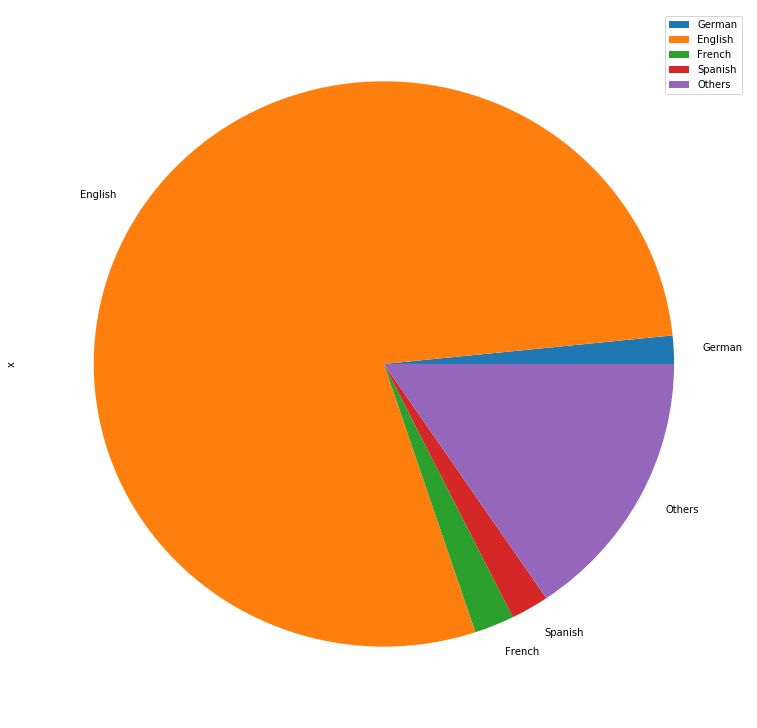

In [94]:
dict_pie = {'Others':0}
for key,val in dict_languages.items():
    if key == 'es':
        dict_pie['Spanish'] = val
        continue;
    if key == 'de':
        dict_pie['German'] = val
        continue
    if key == 'fr':
        dict_pie['French'] = val
        continue
    if key == 'en':
        dict_pie['English'] = val
        continue
    dict_pie['Others'] = dict_pie['Others'] + val
    
df = pd.DataFrame(dict_pie.values(), index=dict_pie.keys(), columns=['x'])

df.plot(kind='pie', subplots=True, figsize=(13, 13))



In [18]:
# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer



#data = [u'hello I love you more hi bye',u'hello I love you more hi bye say ', u'hello I love you more hi bye class class',u'create a python sql cpp',u'contact your mom dad son']
y = [int(1) for i in range(len(data))]

#X_test = [u'The people of Germany are turning against their leadershipas migration is rocking the already tenuous Berlin coalition. Crime in Germany is way up. Big mistake made all over Europe in allowing millions of people in who have so strongly and violently changed their culture!t!']

#X_test = ['Hey Joe,Wondering why this website: http://www.iiseagrant.org/wilmettebuoy/  and this website: http://www.ndbc.noaa.gov/station_page.php?station=45174 … show different wind dir / speed ind dir / speed ind dir / speed']
#X_test = [' Colombia animo Minutos cruciales para la democracia, votemos  Escuchemos a empresarios y trabajadores sobre la transición y prohibición del asbesto Gratitud con el Congreso de la República que acaba de aprobar el proyecto de ley por el cual se brindan condiciones para mejorar la calidad de vida del adulto mayor en Colombia']
#X_test =['Low plastic stool, cheap but delicious noodles, cold Hanoi beer.” This is how I’ll remember Tony. He taught us about food — but more importantly, about its ability to bring us together. To make us a little less afraid of the unknown. We’ll miss him.']
# Transform the training data: tfidf_train 
#X_test = ['I live in a border state. border state I appreciate the need to enforce and protect our international boundaries, but this zero-tolerance policy is cruel. It is immoral. And it breaks my heart.']

tfidf_train = tfidf_vectorizer.fit_transform(data)


WX_test= test_tweets

# Transform the test data: tfidf_test 
#tfidf_test = tfidf_vectorizer.transform(X_test)
# Initialize a TfidfVectorizer object: tfidf_vectorizer

## Build KNN model
#modelknn = KNeighborsClassifier(n_neighbors=1)
#modelknn.fit(tfidf_train,y)

NameError: name 'test_tweets' is not defined

In [20]:
print(obamatweets.text.values[3:4]  )

NameError: name 'obamatweets' is not defined

In [19]:
obamatweets = pd.read_csv('kanyewest_tweets.csv')
X = obamatweets.text.values[2:3]  
print(X)

X1  = tfidf_vectorizer.transform(X)
X = obamatweets.text.values[3:4]
X2  = tfidf_vectorizer.transform(X)

X1 = X1 + X1 
    
X_test = X1 + X2   

norm = np.sum(X_test.A**2.0)
norm = norm**0.5

X_test /= norm
tfidf_test = X_test

['1...2...3...\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5\xf0\x9f\x94\xa5 https://t.co/IPhCypJOhC']


In [20]:
user_tweets = pd.read_csv('kanyewest_tweets.csv')
user_tweets = user_tweets.text.values[:100]
#print(user_tweets[:100])
all_X_test = tfidf_vectorizer.transform(user_tweets)

weights = range(1,len(all_X_test.A));
weights = sorted(weights,reverse=True)

X_test = all_X_test[0];

for idx,tweet_X in enumerate(all_X_test):
    break
    
    weight = weights[idx]
    
    new_X = weight *tweet_X
    X_test = X_test + new_X
 



norm = np.sum(X_test.A**2.0)
norm = norm**0.5

X_test /= norm
tfidf_test = X_test

In [21]:
#tfidf_test = tfidf_vectorizer.transform(X_test[:10])




## Here we calculate the cosine similarity

In [22]:
# Get the cosine similarity between tweet and podcast
a= np.dot(tfidf_test,tfidf_train.T)
print("cosine sim. values : " +str(a.A))
#sort the index from closest to fartherst
a_sort = np.argsort(a.A)
print("index from closest to farthest away : "  + str(a_sort))

cosine sim. values : [[0. 0. 0. ... 0. 0. 0.]]
index from closest to farthest away : [[    0 61469 61468 ... 38806 24972 23199]]


### Let's plot the a histogram for the cosine similarity frequency 

Text(0.5,0,u'cosine similarity')

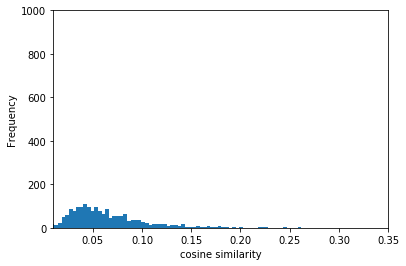

In [23]:
plt.hist(a.A.flatten()[:], bins=100)
plt.xlim((0.01,0.35))
plt.ylim((0,1000))
plt.ylabel('Frequency')
plt.xlabel('cosine similarity')

Text(0.5,0,u'cosine similarity')

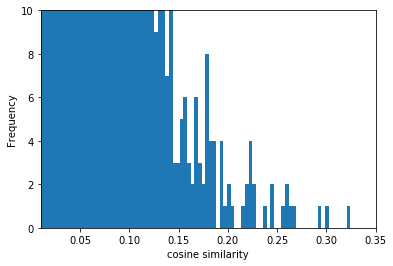

In [24]:
plt.hist(a.A.flatten()[:], bins=100)
plt.xlim((0.01,0.35))
plt.ylim((0,10))
plt.ylabel('Frequency')
plt.xlabel('cosine similarity')

### Let's get the first 100 closest podcasts!

In [25]:
max_vals_idx =  a_sort.flatten()[::-1][:100]

In [28]:
def get_from_tfidf(user ='kanyewest'):
    user_tweets = pd.read_csv(user + '_tweets.csv')
    user_tweets = user_tweets.text.values[:100]
    #print(user_tweets[:100])
    all_X_test = tfidf_vectorizer.transform(user_tweets)

    weights = range(1,len(all_X_test.A));
    weights = sorted(weights,reverse=True)

    X_test = all_X_test[0];

    for idx,tweet_X in enumerate(all_X_test):
        break

        weight = weights[idx]

        new_X = weight *tweet_X
        X_test = X_test + new_X




    norm = np.sum(X_test.A**2.0)
    norm = norm**0.5

    X_test /= norm
    tfidf_test = X_test
    
    # Get the cosine similarity between tweet and podcast
    a= np.dot(tfidf_test,tfidf_train.T)
    #print("cosine sim. values : " +str(a.A))
    #sort the index from closest to fartherst
    a_sort = np.argsort(a.A)
    #print("index from closest to farthest away : "  + str(a_sort))
    
    max_vals_idx =  a_sort.flatten()[::-1][:20]
    podcast_descriptions = []
    for idx in max_vals_idx:
        podcast_descriptions.append(data[idx]) 

    #print(podcast_descriptions[:10])
    urls  = final_df.loc[max_vals_idx].website_url.values.tolist()
    final_urls = random.sample(urls,3)
    return final_urls,podcast_descriptions , max_vals_idx;


tfidf_urls, podcast_descriptions, max_vals_idx = get_from_tfidf()

tfidf_urls


['http://www.liberationfrequency.co.uk/ground-level-podcast/',
 'http://www.jurinspired.com',
 'http://www.blogtalkradio.com/plantingseedsforpeace']

### Let's look at the URLs!

In [27]:
t = final_df.loc[max_vals_idx]
t.website_url[:20]

23199                        http://www.spiritfilledcc.com
24972                   http://christfellowshippreston.com
38806    http://www.liberationfrequency.co.uk/ground-le...
62804                              http://PeaceNewsNow.com
59022                http://musicgeneration.webs.com/downl
65026                    http://podshowradio.blogspot.com/
87208               http://www.blogtalkradio.com/ventradio
62806               http://peacepoemsbytimpr.blogspot.com/
28314                         http://creativecommoners.net
19927                           http://www.brightlounge.tv
46613                           http://www.jurinspired.com
50431                       http://podnutz.com/lftrou/feed
44746                      http://www.italytravelnotes.com
68814                http://www.blogtalkradio.com/thapanel
65316                               http://www.rssmix.com/
46125                               http://www.rssmix.com/
30911                               http://www.rssmix.co

### Let's look at the Podcasts Descriptions!

In [29]:
podcast_descriptions = []
for idx in max_vals_idx:
    podcast_descriptions.append(data[idx]) 

podcast_descriptions[:20]

[u'Thank You. ',
 u'A church for the rest of us... ',
 u'The discussion show for the rest of us... ',
 u'Peace is the way. ',
 u'No Peace In War ',
 u'Words and Music for the Rest of Us ',
 u'There will be no more shows for now guys. Thank you to all those who came and were a big part of the art and peace this show tried to create with you. ',
 u'Poems of Peace ',
 u'A podcast on creativity for the rest of us ',
 u'Relax and Be Inspired ',
 u'inspired by the law ',
 u'Linux For The Rest Of Us Podcast ',
 u'From those inspired by Italy ',
 u'Here we are again on the move!! Thank you for tuning into our shows on "The Panel" on Sunday at 7pm, "Now, How Bout It" on Mondays at 7pm . We will work hard to continue to bring you the best shows that we can that you the listeners want us to give to you. Thank you for your support again. . .Peace ',
 u'This feed was created by mixing existing feeds from various sources. ',
 u'This feed was created by mixing existing feeds from various sources. ',


In [28]:

Xtr = tfidf_vectorizer.transform(podcast_descriptions)
features = tfidf_vectorizer.get_feature_names()


In [30]:
def top_tfidf_feats(row, features, top_n=25):
    
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_feats_in_doc(Xtr, features, row_id, top_n=25):

    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [32]:
Xtr = tfidf_vectorizer.transform(podcast_descriptions)
features = tfidf_vectorizer.get_feature_names()

buzz_words = []
for i in range(10):
    a = top_feats_in_doc(Xtr, features, row_id=i, top_n=25)
    word = a.feature.values.tolist()[0]
    buzz_words.append(word)

final_string = set(buzz_words)
buzz_words = list(final_string)
final_string = random.choice(buzz_words)
for i in range(1):
    
    trial_word = random.choice(buzz_words)
    final_string = final_string + "+" + trial_word

#signal_string = final_string[0] + "+" +final_string[1]+ "+" + final_string[2] + "+"+ final_string[3]
final_string

u'relax+tried'

In [33]:
import unirest

In [46]:
def get_from_listen_notes():
    Xtr = tfidf_vectorizer.transform(podcast_descriptions)
    features = tfidf_vectorizer.get_feature_names()

    buzz_words = []
    for i in range(10):
        a = top_feats_in_doc(Xtr, features, row_id=i, top_n=25)
        word = a.feature.values.tolist()[0]
        buzz_words.append(word)

    final_string = set(buzz_words)
    buzz_words = list(final_string)
    final_string = random.choice(buzz_words)
    for i in range(1):

        trial_word = random.choice(buzz_words)
        final_string = final_string + "+" + trial_word
    print(final_string)
    response = unirest.get("https://listennotes.p.mashape.com/api/v1/search?genre_ids=68%2C100&language=English&len_max=60&len_min=2&offset=0&only_in=Only+search+in+these+fields&published_after=1390190241000&published_before=1490190241000&q=" + final_string + "&sort_by_date=0&type=episode",
      headers={
        "X-Mashape-Key": "2i4tvJvbnFmshAM8KCc4CZaPh7ejp1ZzKA0jsnVI8C398lRK4S",
        "Accept": "application/json"
      }
    )

    listen_notes_pods = response.body['results']


    response_listen_notes=[]
    if len(listen_notes_pods)> 0:
        rand_pod = random.choice(listen_notes_pods)
        response_listen_notes.append(rand_pod[u'audio'])

    return response_listen_notes

a = get_from_listen_notes()


relax+peace


[u'https://www.listennotes.com/e/p/0444c5fcaf404054a8248c7489631fe5/']

In [47]:
url_listen_notes = a

In [35]:
def split_hashtag(hashtagestring):
    fo = re.compile(r'#[A-Z]{2,}(?![a-z])|[A-Z][a-z]+')
    fi = fo.findall(hashtagestring)
    result = ''
    for var in fi:
        result += var + ' '
        #print (result)
    result = result.split()
    return result;


    
    

In [50]:
def get_from_hashtag(all_hashtags):
    all_bi_tokens = []
    for h_tag in all_hashtags:
        
        trial_bitoken = split_hashtag(h_tag)
       # print(trial_bitoken)
        if len(trial_bitoken) > 1:
            all_bi_tokens.append(trial_bitoken)
    
    hash_signal = random.choice(all_bi_tokens)
    final_hash_signal = hash_signal[0]
    h_tag_user = "@" + hash_signal[0]
    
    
    
    Celebrity = True;
    while Celebrity:
        for i in range(1,len(hash_signal)):
            final_hash_signal = final_hash_signal + "+" + hash_signal[i]
            h_tag_user = h_tag_user + hash_signal[i]
        
        try:
            user = api.get_user(h_tag_user)
        
        except tweepy.error.TweepError as e:
            time.sleep(180)
            user = api.get_user(h_tag_user)
        try:
            
            nbr_friends = user.followers_count
            
            
        except tweepy.error.TweepError as e:
            time.sleep(180)
            nbr_friends = user.followers_count
            
        if nbr_friends > 1000000:
            Celebrity = False;
            
        else:
            hash_signal = random.choice(all_bi_tokens)
            final_hash_signal = hash_signal[0]
            h_tag_user = "@" + hash_signal[0]
        
    response = unirest.get("https://listennotes.p.mashape.com/api/v1/search?genre_ids=68%2C110&language=English&len_max=50&len_min=2&offset=0&only_in=Only+search+in+these+fields&published_after=1390190241000&published_before=1490190241000&q=" + final_hash_signal + "&sort_by_date=0&type=episode",
    headers={
    "X-Mashape-Key": "2i4tvJvbnFmshAM8KCc4CZaPh7ejp1ZzKA0jsnVI8C398lRK4S",
    "Accept": "application/json"
              }
            )

    listen_notes_pods = response.body['results']


    response_listen_notes=[]
    if len(listen_notes_pods)> 0:
        rand_pod = random.choice(listen_notes_pods)
      #  print(rand_pod)
        response_listen_notes.append(rand_pod[u'audio'])
        
        
    return response_listen_notes, h_tag_user,final_hash_signal

url_hashtag,b,c = get_from_hashtag(["BarackObama"] )

url_hashtag

[u'https://www.listennotes.com/e/p/b2a08ede069b4408bbefd18f2a3d17d1/']

In [37]:
import tweepy
import random
#from our keys module (keys.py), import the keys dictionary

CONSUMER_KEY = "HGsCa24B9jlGFiDpRaBemTyjj"
CONSUMER_SECRET = "BA87yf8QyolGnTUmHEc07A1ZfnKbmHa6GfMRj3tBEJ8lWMFGPH"
ACCESS_TOKEN = "1006801061754097664-I7ziYNHGJ3ydUPgtEP0wYEvTBYuWJz"
ACCESS_TOKEN_SECRET = "Xz3kwLMXd7UYDpkyjNMfXn5ATnW3njLNVuybST3ci5v3k"

#CONSUMER_KEY = "tNq5rXzQtpCfQN5SqhvYDjx84"
#CONSUMER_SECRET = "3KTXCM4jVgizY1MCPHCm02oxV21OBMdX2jGAfY7mZ27aSbwveF"
#ACCESS_TOKEN = "1003684959419322371-2yvCMWHGhs7S32TIgEY9wV9SziKg11"
#ACCESS_TOKEN_SECRET = "MyIrkq24K7R7WehRLeRkpVCePbmQB7L56He65gfeaLgAw"


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [42]:
import itunes
import unirest
import tweet_dumper
import time

In [102]:
def get_user_tweets(screen_name):
    new_tweets = api.user_timeline(screen_name = screen_name,count=200)
    try:
        user = api.get_user(screen_name)
    except tweepy.error.TweepError as e:
        time.sleep(180)
        user = api.get_user(screen_name)
    try:
        friends = user.friends()
        
    except tweepy.error.TweepError as e:
        time.sleep(180)
        friends = user.friends()
    #print(user.screen_name)
    all_friends = []
    for friend in friends:
        all_friends.append(friend.screen_name)
    
    alltweets = []
    if len(new_tweets) < 1:
        
        return []
    #save most recent tweets
    alltweets.extend(new_tweets)

    #save the id of the oldest tweet less one

    if len(new_tweets) > 0:
        
        oldest = alltweets[-1].id - 1

    #keep grabbing tweets until there are no tweets left to grab
    while len(new_tweets) > 0:
        #print "getting tweets before %s" % (oldest)

    #all subsiquent requests use the max_id param to prevent duplicates
        try:
            new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
                
        except tweepy.error.TweepError as e:
            time.sleep(180)
            new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
            
            
    #save most recent tweets
        alltweets.extend(new_tweets)

        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        
        #print(oldest)

        #print "...%s tweets downloaded so far" % (len(alltweets))

        #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]
    return all_friends,outtweets

##  BOT MAIN BODY
## BOT MAIN BODY


In [104]:
#Get history of tweets 
#public_tweets = api.home_timeline()
podcast_url = tfidf_urls[0] + " "+ tfidf_urls[1] + " "  +tfidf_urls[2] + " " + url_listen_notes[0] + " " + url_hashtag[0]
#podcast_url = url_hashtag[0]
try:
    public_tweets = api.mentions_timeline()
except tweepy.error.TweepError as e:
    time.sleep(180)
    public_tweets = api.mentions_timeline()
    
print(len(public_tweets))
#look at first tweet only for now
idx= 0 ;

#loop through twwets in timeline
for i in range(1):
    print("loop: " + str(i))
    for idx,tweet in enumerate(public_tweets):
       
        #print("found tweet :" + str(idx))
        print(tweet.text)
        #break on other tweets
        if idx >0:
            break;

        #split tweet to get username
        try:
            buffer_str =str(tweet.text).split()
        except tweepy.error.TweepError as e:
            time.sleep(180)
            buffer_str =str(tweet.text).split()

        #get into first tweet
        if idx == 0:
                #m = buffer_str[0] + " podcast"
                #print(m)
                #print(tweet.id)
                #print('tweet content : ' + str(tweet.text))

                
                #user info
                sn = str()
                try:
                    #user = api.get_user(tweet.id)
                    #user screen name
                    sn = tweet.user.screen_name
                except tweepy.error.TweepError as e:
                    time.sleep(180)
                    
                    #user screen name
                    sn = tweet.user.screen_name
                print(sn)
                    
                #print("sending recommendation to @" + str(sn))

                #get all twitter history from user
                #all_tweets = get_user_tweets(sn)
                #print("getting obama tweets")
                
                #try:
                 #   all_tweets = get_user_tweets('BarackObama')
                #except tweepy.error.TweepError as e:
                 #   time.sleep(180)
                  #  all_tweets = get_user_tweets('BarackObama')
                    
                m = "@" + sn + " listen "  + podcast_url
                #m = u"@" +sn + u" haha " + u'https://itunes.apple.com/us/podcast/ted-talks-daily/id160904630?mt=2&uo=4'
                
               
                print(m)
                #ok now notify user , case 1  : user has no much history
                all_tweets =range(15)
                if sn != "PFather101" and len(all_tweets) < 10:
                    try:
                        s = api.update_status(m, tweet.id)
                    except tweepy.error.TweepError as e:
                        time.sleep(180)
                        s = api.update_status(m, tweet.id)
                    
                    print("reply sent going to sleep")
                    #time.sleep(1*60)
                    print("awake")

                #case 2 : user has history
                if sn != "PFather101" and len(all_tweets) > 10:
                    try:
                        s = api.update_status(m, tweet.id)
                    except tweepy.error.TweepError as e:
                        time.sleep(180)
                        s = api.update_status(m, tweet.id)  
                    print("reply sent to @" + str(sn))
                    print("reply sent going to sleep")
                    #time.sleep(1*60)
                    print("awake")
        idx= idx+1
            



15
loop: 0
@PFather101 hello demo !!!
jandresmillan
@jandresmillan listen http://www.liberationfrequency.co.uk/ground-level-podcast/ http://www.jurinspired.com http://www.blogtalkradio.com/plantingseedsforpeace https://www.listennotes.com/e/p/0444c5fcaf404054a8248c7489631fe5/ https://www.listennotes.com/e/p/b2a08ede069b4408bbefd18f2a3d17d1/
reply sent to @jandresmillan
reply sent going to sleep
awake
@PFather101 hello demo 3!!!!


In [67]:
len(tfidf_urls)

3

In [101]:
podcast_url

u'http://www.liberationfrequency.co.uk/ground-level-podcast/ http://www.jurinspired.com http://www.blogtalkradio.com/plantingseedsforpeace https://www.listennotes.com/e/p/0444c5fcaf404054a8248c7489631fe5/ https://www.listennotes.com/e/p/b2a08ede069b4408bbefd18f2a3d17d1/'

In [831]:
def clean_weird_chars(stream_data):
    new_data = []
    for idx,sentence in enumerate(stream_data):
        new_sentence=str()
        try:

            new_sentence =  re.sub('\S*@\S*\s?', '', sentence)

        except:
             continue;

        try:

            new_sentence =  re.sub('\s+', ' ', new_sentence)

        except:
             continue;   

        try:

            new_sentence =  re.sub("\'", "", new_sentence)

        except:
             continue;
        try:
            re.sub(r'^https?:\/\/.*[\r\n]*', '', new_sentence, flags=re.MULTILINE)
        
        except:
             continue;

        new_data.append(new_sentence)

    return new_data;

In [748]:
def clean_asian(streamdata):
    bad_ids= []
    good_ids = []
    for idx,_sentence in enumerate(streamdata):

        if isinstance(_sentence,float):
            bad_ids.append(idx)
            continue

        tokens = _sentence.split()
        new_string = str()

        ADD_STRING = True
        for t in tokens:
            try:
                t.encode('utf-8')

                new_string = new_string +  t.encode('utf-8')+ ' '

            except:
                bad_ids.append(idx)
                ADD_STRING = False
                break
        if ADD_STRING:
            new_data.append(new_string)
            good_ids.append(idx);
    
    return good_ids,bad_ids;

In [753]:
last_podcast = clean_weird_chars(podcast_descriptions)

In [754]:
print(last_podcast)

[u'Thank You. ', u'A church for the rest of us... ', u'The discussion show for the rest of us... ', u'Peace is the way. ', u'No Peace In War ', u'Words and Music for the Rest of Us ', u'There will be no more shows for now guys. Thank you to all those who came and were a big part of the art and peace this show tried to create with you. ', u'Poems of Peace ', u'A podcast on creativity for the rest of us ', u'Relax and Be Inspired ', u'inspired by the law ', u'Linux For The Rest Of Us Podcast ', u'From those inspired by Italy ', u'Here we are again on the move!! Thank you for tuning into our shows on "The Panel" on Sunday at 7pm, "Now, How Bout It" on Mondays at 7pm . We will work hard to continue to bring you the best shows that we can that you the listeners want us to give to you. Thank you for your support again. . .Peace ', u'This feed was created by mixing existing feeds from various sources. ', u'This feed was created by mixing existing feeds from various sources. ', u'This feed was

In [736]:
def sent_to_words(sentences):
    for sentence in sentences:
        
        try:
            a = gensim.utils.simple_preprocess(str(sentence), deacc=True)
            
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        except:
            
            continue
            


In [737]:
data_words = list(sent_to_words(last_podcast))

In [738]:
data_words

[[u'thank', u'you'],
 [u'church', u'for', u'the', u'rest', u'of', u'us'],
 [u'the', u'discussion', u'show', u'for', u'the', u'rest', u'of', u'us'],
 [u'peace', u'is', u'the', u'way'],
 [u'no', u'peace', u'in', u'war'],
 [u'words', u'and', u'music', u'for', u'the', u'rest', u'of', u'us'],
 [u'there',
  u'will',
  u'be',
  u'no',
  u'more',
  u'shows',
  u'for',
  u'now',
  u'guys',
  u'thank',
  u'you',
  u'to',
  u'all',
  u'those',
  u'who',
  u'came',
  u'and',
  u'were',
  u'big',
  u'part',
  u'of',
  u'the',
  u'art',
  u'and',
  u'peace',
  u'this',
  u'show',
  u'tried',
  u'to',
  u'create',
  u'with',
  u'you'],
 [u'poems', u'of', u'peace'],
 [u'podcast', u'on', u'creativity', u'for', u'the', u'rest', u'of', u'us'],
 [u'relax', u'and', u'be', u'inspired'],
 [u'inspired', u'by', u'the', u'law'],
 [u'linux', u'for', u'the', u'rest', u'of', u'us', u'podcast'],
 [u'from', u'those', u'inspired', u'by', u'italy'],
 [u'here',
  u'we',
  u'are',
  u'again',
  u'on',
  u'the',
  u'move

In [715]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

[u'thank', u'you']


In [716]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [717]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en')

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

[[u'thank'], [u'church', u'rest'], [u'discussion', u'show', u'rest'], [u'peace', u'way'], [u'peace']]


In [718]:
#Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [719]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[(u'thank', 1)]]

In [720]:
len(corpus)

100

In [739]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=1, 
                                           random_state=400,
                                           update_every=100,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [740]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  u'0.038*"https" + 0.026*"peace" + 0.021*"www" + 0.021*"facebook" + 0.014*"rest" + 0.011*"thank" + 0.010*"twitter" + 0.010*"podcast" + 0.010*"show" + 0.010*"soundcloud"')]


In [730]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

(u'\nPerplexity: ', nan)
(u'\nCoherence Score: ', 0.5481571997811233)


In [731]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

ValidationError: 
 * Not all rows (distributions) in topic_term_dists sum to 1.
 * Not all rows (distributions) in doc_topic_dists sum to 1.

In [732]:
top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 20)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words.csv")

In [733]:
top_words_lda = pd.read_csv('top_words.csv')

In [734]:
top_words_lda

,Unnamed: 0,Topic,Word,P
0,0,0,aggression,NaN
1,1,0,not,NaN
2,2,0,matter,NaN
3,3,0,morning,NaN
4,4,0,need,NaN
5,5,0,hate,NaN
6,6,0,adam_smasher,NaN
7,7,0,amateur,NaN
8,8,0,comedian,NaN
9,9,0,journey,NaN
